# Cluster Analysis of Kaggle 2021 Survey Participants

## Introduction
This analysis identifies three clusters of 2021 Kaggle survey participants by **k-means clustering** method. By digging further of each cluster, we name them as **explorers**, **climbers** and **experts**, depending on how they respond questions in regards of demographics, professions, their skill and knowledge in data science, the tools they are frequently using and tools they plan to get more familiar in the next two years.


## Motivation
This analysis tries to answer -

1. How many types of professionists in the data science field?
2. How does each segment of data science professionsts differ in demographics, professions, their skill and knowledge in data science, the tools they are frequently using and tools they plan to get more familiar in the next two years?

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pyarrow
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# functions
def rename_columns(df):
    """
    input: the dataset we want to rename the columns
    output: combine the first row of the dataset into the original column
    """
    original_columns = df.columns
    num_col = df.shape[1]
    first_row = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data below the first row
    # create a list containing new column names
    new_cols = []
    for col in range(num_col):
        new_col_name = original_columns[col] + '_' + first_row[col]
        new_cols.append(new_col_name)
    df.columns = new_cols # assign the new column names to the dataset
    return df

def replace_nan(df):
    """
    input:
    df - the target dataset
    
    output:
    a new dataset with nan values replaced as 0 and non-nan values replaced with 1
    """
    array = np.where(df.isnull(),0,1)
    df = pd.DataFrame(data=array, columns=df.columns)
    df.index = df.index + 1
    return df

def split_cols(df):
    """
    input:
    df - target dataframe
    
    output:
    single_questions - a list of column names that belong to single question column
    multiple_questions - a list of column names that belong to multiple question column
    """
    single_questions = []
    multiple_questions = []
    for col in df.columns:
        if 'part' in col.lower() or 'other' in col.lower():
            multiple_questions.append(col)
        else:
            single_questions.append(col)
    return single_questions, multiple_questions

def pivot_col(df, col):
    """
    input:
    df - target dataset
    col - the column we want to pivot its value as new columns
    
    output:
    return a pivoted dataframe where columns are value from the col of old dataframe
    """
    df['participant_id'] = df.index
    pivoted_df = df.pivot(index = 'participant_id', columns=col, values=col).reset_index().iloc[: , 1:]
    pivoted_df.index = pivoted_df.index + 1
    return pivoted_df

def pivot_df(df):
    """
    input:
    df - targer dataframe
    var_cols - a list of column names we want to pivot
    aggr - the column we used to group by the dataset
        
    output:
    return a dataframe where each column comes from value of each col of old dataframe
    NaN value replaced with 0 while non-NaN value replaced with 1
    """
    
    pivoted_df = []
    for col in df.columns:
        if col in single_questions: ## single question answers
            pivoted = pivot_col(df[[col]], col)
            pivoted_df.append(pivoted)
        else:
            pivoted_df.append(df[[col]])
    pivoted_merged_df = pd.concat(pivoted_df, axis=1, ignore_index=False)
    return pivoted_merged_df

def closest_participant(participant_id, participant_matrix):
    """
    input:
    participant_id - target participant
    participant_matrix - matrix where shows the similarity between each participant
    
    output - the list of participants other than the target participant, ranked by similarity
    """
    participant_list = participant_matrix[[participant_id]]
    participant_list = participant_list.sort_values(by = participant_id, ascending = False)
    
    return participant_list.index[1:]

def compensation(df , participant):
    """
    input -
    df - target dataset
    participant - the id of the participant
    
    output -
    the yearly compensation of that participant
    """
    
    compensation = df.loc[df.index == participant]['Q25_What is your current yearly compensation (approximate $USD)?'].iloc[0]
    
    return compensation

def similar_user_compensation(df, participant_ids):
    """
    input:
    df - target dataset
    participant_ids - a list of participant ids
    output:
    the first participant id that has non-null compensation data
    """
    for participant in participant_ids:
        if compensation(df, participant) is not None:
            return compensation(df, participant)
        else:
            pass

def same_answers(df, user_1, user_2):
    """
    input
    df - target dataset
    user_1 - index number of user 1
    user_2 - index number of user 2
    
    output
    same_cols - return the column names where answer are same between user 1 and 2
    different_cols - return the column names where answer are different between user 1 and 2
    """
    same_cols = []
    different_cols = []
    answers = df.loc[df.index.isin([user_1,user_2])]
    for col in answers.columns:
        if answers[col].iloc[0] == answers[col].iloc[1]:
            same_cols.append(col)
        else:
            different_cols.append(col)
    return same_cols, different_cols

def compute_correlation(df, user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    df - dataset where is a matrix of user and their pivoted answer columns
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    answer_1 = list(df.loc[df.index == user1].iloc[0])
    answer_2 = list(df.loc[df.index == user2].iloc[0])
    
    dot_product = np.vdot(answer_1, answer_2)
    
    return dot_product #return the correlation

def subset_data(df, col, criteria):
    """
    input:
    df: the dataset we want to subset from
    col: target columns as the filter
    criteria: value to feed the filter
    
    output:
    a new dataset which is a subset of the original one
    """
    
    new_df = df.loc[df[col] == criteria]
    
    return new_df

def question_columns(df, query, method = 'strict'):
    """
    input: 
    df - target dataset
    query - str, query we want to find relevant infomation in the dataset. e.g. 'Q7', or 'machine learning' 
    
    output:
    a subset of data which include the columns of the query in interest
    
    method:
    if it == strict, which means we will look for the question exactly EQUALS to the query. e.g. if we search 'age', then 'language' won't
    be taken into account in this case;
    
    if it == loose, which means we will look for the question exactly CONTAINS the query. e.g. if we search 'age', then 'language' will
    be taken into account in this case.
    """
    columns = df.columns
    question_col = []
    for col in columns:
        if method == 'strict':
            col_parts = col.lower().split() # each column name will be separated into single word tokens at first
            if query.lower() in col_parts:
                question_col.append(col)
        elif method == 'loose':
            if query.lower() in col.lower():
                question_col.append(col)
    return df[question_col]

def kmeans_cluster_opt(df, init = 'k-means++', max_num_cluster = 9):
    """
    input: 
    df - the dataset we want to segments into cluster
    init - the way we want to initialize the starting centroid
    max_num_cluster - the max number of cluster
    
    output:
    a visualization showing the line graph indicating the optimal number of klusters, based on inertias value
    """
    num_clusters = list(range(1, max_num_cluster))
    inertias = []

    for k in num_clusters:
        model = KMeans(init=init, n_clusters=k, random_state = 42)
        model.fit(df)
        inertias.append(model.inertia_)

    
    plt.plot(num_clusters, inertias, '-o')

    plt.xlabel('number of clusters (k)')
    plt.ylabel('inertia')

    plt.show()

def kmeans_predict(df, init = 'k-means++', n_clusters = 4):
    """
    input:
    df - dataset we want to segment into clusters
    init - the way we want to initialize the starting centroid
    n_clusters - the number of cluster
    
    output:
    labels - return an array of predictions on the cluster label of given features
    centers - centroid values of each cluster
    """
    model = KMeans(init=init, n_clusters = n_clusters, random_state = 42)

    model.fit(df)

    labels = model.predict(df)
    
    centers = np.array(model.cluster_centers_)
    
    return labels, centers

def percentage_row(df):
    """
    input:
    df - target dataframe
    
    output - a new dataframe in which each cell represents the row 
    percengatge value of the corresponding one in the target dataframe
    
    """
    new_df = df.div(df.sum(axis=1), axis=0)
    new_df_share = round(new_df.apply(lambda x: x*100), 1).reset_index()
    return new_df_share

def cluster_aggr(df, cols):
    """
    input
    df: target dataset
    
    cols: columns of the question we are interested to see the segmentation
    
    output:
    a new dataframe that contains the number of participants for each question option
    """
    aggr = df.groupby(['cluster']).sum()
    aggr_col = aggr.iloc[:, cols]
    aggr_col = aggr_col.loc[:, (aggr_col != 0).any(axis=0)]
    aggr_col.loc["Total"] = aggr_col.sum()

    
    return aggr_col

def plot_bar_perc(df, cols):
    """
    input:
    df - target dataframe
    cols - columns we want to present as bars in the outcome chart
    
    output:
    a bar chart where each bar represents the share of each value in the column aggregated by cluster
    """
    fig = make_subplots(rows=1, cols=3, 
                    start_cell="bottom-left", 
                        shared_yaxes=True,
                    subplot_titles=(cluster_title))

    clusters = df.index.tolist()

    options = df.columns[1:]

    colors = single_blue * len(options)

    for c in range(len(clusters)):
        data = df.loc[df['cluster'] == clusters[c]] 
        for o in range(len(options)):
            fig.add_trace(go.Bar(x=[options[o]], 
                             y=data[options[o]],
                             marker_color = colors[o]),
                              row=1, col=c+1)
        
    fig.update_layout(
        title="% of each option chosen by participants per cluster",
        yaxis_title="% of participants",
        showlegend=False)
    fig.show()
    
def cluster_question_plot(df, question):
    """
    input:
    df - target dataset
    
    question - the question we are interested to segmented by the cluster
    
    output:
    a list which contains a table and a plot showing the share of each segment per cluster
    """
    aggr_data = cluster_aggr(df, range(qs_num[question][0], qs_num[question][1]))
    aggr_perc = percentage_row(aggr_data)
    plot_data = aggr_perc.loc[aggr_perc['cluster'].isin([0,1,2])]
    
    plot_chart = plot_bar_perc(plot_data, plot_data.columns[1:])
    
    return aggr_perc, plot_chart

def plot_bar_rank(df, cols, num_col = 10):
    """
    input
    df: target dataframe
    cols : Question you want to aggregate
    num_col: number of options shown in the chart
    
    output:
    return a bar chart where options with highest total shares are set at the left side
    """
    data_aggr = cluster_aggr(df, range(qs_num[cols][0], qs_num[cols][1]))
    data_aggr = percentage_row(data_aggr)
    data_aggr_rank = rank_total(data_aggr)

    top_data_aggr_rank_cols = ['cluster']
    for col in data_aggr_rank.columns:
        top_data_aggr_rank_cols.append(col)
    
    aggr_cols = data_aggr.columns

    data_aggr = data_aggr.loc[data_aggr['cluster'].isin([0,1,2])]

    plot_bar_perc(data_aggr[top_data_aggr_rank_cols[:num_col]], aggr_cols)

def std_cluster(df):
    """
    input:
    df - target dataframe
    output:
    std - standard deviation of each row per cluster
    """
    std = df.iloc[:,1:].std(axis=1)
    return std

def rank_total(df):
    """
    input: target dataframe
    
    output: a new dataframe which columns are ranked by the value in the Total row, so higher values are set at the left side
    """
    df = df.iloc[:,1:] # remove cluster column
    df_ranked = df.sort_values(by = 3, axis=1 , ascending = False)
    return df_ranked

def find_correlation_rank(df,col,ascending = False):
    """
    input:
    df - target dataframe
    col - column in interest
    
    output:
    a list of columns in which the highest positive correlated col ranks the first
    """
    df_ranked = df[[col]].sort_values(by = col,ascending = ascending)
    
    return df_ranked

In [2]:
# color palatte for visualization
shades_blue = ['#90EE90','#00FF7F','#00FFFF','#89CFF0','#1434A4','#0096FF',
               '#6495ED','#1F51FF','#2F4F4F','#A7C7E7','#00008B']

single_blue = ['#89CFF0']

## Data Cleaning
The dataset is from [Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/competitions/kaggle-survey-2021). According to the competition host, it has collected 25,973 valid answers from Kaggle users. Kaggle is a free online data science community where participants could attend data science competitions. Its annual survey is representative to understand professionists in the data science world.

In [3]:
# load dataset
data = pd.read_parquet("/Users/jasmine/udacity_ds_nano_degree_capstone/data.parquet")

# first five rows
# data.head()

# remove the column Time from Start to Finish (seconds)
data = data.iloc[: , 1:]

# size of the dataset
data.shape # 25973 rows, 369 columns

print("The dataset has " + str(data.shape[0]) + " rows.")

print("The dataset has " + str(data.shape[1]) + " columns.")

The dataset has 25974 rows.
The dataset has 368 columns.


In [4]:
# make question as columne names
renamed_data = rename_columns(data)

# group questions into two categories
# single_questions if it is a single answer question
# multiple_questions if it is a multiple answer question
single_questions = split_cols(renamed_data)[0]
multiple_questions = split_cols(renamed_data)[1]

# pivot the dataset to one option one column
# turn answer as binary data where chosen is 1 and not chosen is 0 
pivoted_data = pivot_df(renamed_data)
binary_data = replace_nan(pivoted_data)

# Question and its number of columns
qs_num = {
    "Age" : [0,11],
    "Gender" : [11,16],
    "Country" : [16,82],
    "HighEdu" : [82,89],
    "Employment" : [89,104],
    "CodeExp" : [104,111],
    "ProgLangReg" : [111,125],
    "ProgLangRec" : [125,138],
    "IDE" : [138,151],
    "HostNotebook" : [151, 169],
    "CompPlatMost" : [169,175],
    "HardwareReg" : [175,182],
    "TPUtimes" : [182, 187],
    "VisualLib" : [187,200],
    "MLmethd" : [200,209],
    "MLframe" : [209,227],
    "MLalgorithm" : [227,239],
    "CompVis" : [239,246],
    "NLP" : [246,253],
    "Industry" : [253,272],
    "SizeEmployer" : [272,278],
    "SizeDS" : [278,287],
    "DSBusiness" : [287,292],
    "WorkAct" : [292,301],
    "Compensation" : [301,328],
    "InvestDS" : [328, 334],
    "CldCompPltReg" : [334,347],
    "CldCompPltBstExp" : [347,360],
    "CldCompProdReg" : [360,365],
    "DataStoreProdReg" : [365,373],
    "ManageMLProdReg" : [373,383],
    "BigDataProdReg" : [383,405],
    "BigDataProdMost" : [405,425],
    "IntegenceReg" : [425,443],
    "IntegenceMost" : [443,459],
    "IsAutoML" : [459,467],
    "AutoMLReg" : [467,475],
    "MLexperiment" : [475,487],
    "PubShare" : [487,497],
    "Courses" : [497,510],
    "PrimaryTool" : [510,516],
    "FavMedia" : [516,528],
    "CldCompPltNxt" : [528,540],
    "CldCompProdNxt" : [540,545],
    "DataStoreProdNxt" : [545,553],
    "ManageMLProdNxt" : [553,563],
    "BigDataProdNxt" : [563,584],
    "IntegenceNxt" : [584,601],
    "AutoMLCatNxt" : [601,609],
    "AutoMLProdNxt" : [609,617],
    "MLexperimentNxt" : [617,629]
}

<ipython-input-1-aef51b51be30>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['participant_id'] = df.index


## Method
This analysis adopts K-means to find participant clusters based on the pattern how they respond to the survey. It  aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster [link](https://en.wikipedia.org/wiki/K-means_clustering).

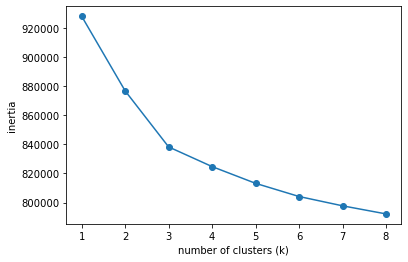

In [5]:
# explore how many number cluster can give a small enough inertia and also be as small number as possible
kmeans_cluster_opt(binary_data)

The chart shows the number 3 is an "elbow" at the line chart, which means segmenting the participants into three clusters could return us a good number of groups and a low error as well.

In [6]:
# create a new column cluster segmenting participants
# As the chart indicates above, we choose to make 3 clusters
binary_data['cluster'] = kmeans_predict(binary_data , n_clusters = 3)[0]

In [7]:
# for visualization use later
# cluster 0 are explorers
# cluster 1 are climbers
# cluster 2 are experts
cluster_title = ["explorers", "climbers", "experts"]

## Analysis

First of all, let's take a look at how many participants per each cluster.

In [8]:
binary_data.groupby(['cluster']).size()

cluster
0    11301
1     6945
2     7727
dtype: int64

We have 11,301 explorers, 6,945 climbers and 7,727 experts.

In [93]:
age_aggr = cluster_aggr(binary_data, range(qs_num["Age"][0], qs_num["Age"][1]))
age_aggr = percentage_row(age_aggr)

cols = age_aggr.columns

cols = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+']

age_aggr = age_aggr.loc[age_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(age_aggr, cols)

C0 and C1 both have highest shares in the age group between 18 to 21, taking 24.9% and 25.4% respectively.
As the age group increases, the share drops.

C2 The highest share age group is 25-29, followed by 30-34 and 35-39, which indicates the C2 participants are more likely older than C0 and C1 cluster participants.

In [91]:
plot_bar_rank(binary_data, "Gender",10)

All three clusters are male dominated. C2 has a relatively even higher share than C0 and C1 by over 7 percentage points. Correspondingly, the share of female participants of C2 is lower than 0 and 1.

In [90]:
plot_bar_rank(binary_data, "Country",15)

C2 participants are more likely to reside in developed countries. C0 has slight more number of participants than C1 residing in developed regions.

Expectedly, C2 don't have clearly more participants than any the other cluster in the BRICS countries, apart from Brazil. India is the biggest country that has the highest share of C1 cluster participants (35%), almost 5 times as the number as of the United States.

In [13]:
edu_aggr = cluster_aggr(binary_data, range(qs_num["HighEdu"][0], qs_num["HighEdu"][1]))
edu_aggr = percentage_row(edu_aggr)

cols = edu_aggr.columns.tolist()

cols = [
 'cluster',
 'No formal education past high school',
 'Some college/university study without earning a bachelor’s degree',
 'Bachelor’s degree',
 'Master’s degree',
 'Professional doctorate',
 'Doctoral degree',
 'I prefer not to answer'
 ]

edu_aggr = edu_aggr[cols]

edu_aggr = edu_aggr.loc[edu_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(edu_aggr, cols)

C2 has the highest share of participants that will have Master’s degree, Professional doctorate	or Doctoral degree as the highest education level in the next 2 years.

In [89]:
plot_bar_rank(binary_data, "Employment",10)

Comparing C2 with C0 and C1 clusers, C2 has the highest, almost 4 times as any of the rest, share (~29.1%) of participants who are data scientists. On the other hand, C1 and 0 have highest shares of Unemployed and Students. 

In [88]:
plot_bar_rank(binary_data, "Industry",10)

Computer and Technology is the most popular industry for all of the clusters, C2 has the highest among the three, 5% and 8 percentage points higher than C1 and C0 respectively. On the other hand, the second most popular industry is Academia/Education. Even though cluster 2 has the highest share of master and doctor degree participants, its share that work in the Academia is comparatively lower. The third most popular industry is Finance/Accounting and the share of each cluster is actually close. 

In [16]:
size_emp_aggr = cluster_aggr(binary_data, range(qs_num["SizeEmployer"][0], qs_num["SizeEmployer"][1]))
size_emp_aggr = percentage_row(size_emp_aggr)

cols = size_emp_aggr.columns.tolist()

cols = ['cluster',
 '0-49 employees',
 '50-249 employees',
 '250-999 employees',
 '1000-9,999 employees',
 '10,000 or more employees']

size_emp_aggr = size_emp_aggr[cols]

size_emp_aggr = size_emp_aggr.loc[size_emp_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(size_emp_aggr, cols)

Small size comannies take the highest share of every cluster, whereas C2 participants are more likely to work in big companies than C0 and C1.

In [17]:
size_ds_aggr = cluster_aggr(binary_data, range(qs_num["SizeDS"][0], qs_num["SizeDS"][1]))
size_ds_aggr = percentage_row(size_ds_aggr)

cols = size_ds_aggr.columns.tolist()

cols = ['cluster',
 '0','1-2','3-4','5-9','10-14','15-19','20+','I do not know']

size_ds_aggr = size_ds_aggr[cols]

size_ds_aggr = size_ds_aggr.loc[size_ds_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(size_ds_aggr, cols)

No surprise, C2 cluster has the higher share of data science colleagues at their employers than any other cluster. Over 40% of participants in either C0 or C1 have no idea how many people working in data scient or they claim none actually works at this field.

In [18]:
ds_business_aggr = cluster_aggr(binary_data, range(qs_num["DSBusiness"][0], qs_num["DSBusiness"][1]))
ds_business_aggr = percentage_row(ds_business_aggr)

cols = ds_business_aggr.columns.tolist()

cols = ['cluster',
 'No (we do not use ML methods)',
 'We use ML methods for generating insights (but do not put working models into production)',
 'We are exploring ML methods (and may one day put a model into production)',
 'We recently started using ML methods (i.e., models in production for less than 2 years)',
 'We have well established ML methods (i.e., models in production for more than 2 years)']

ds_business_aggr = ds_business_aggr[cols]

ds_business_aggr = ds_business_aggr.loc[ds_business_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(ds_business_aggr, cols)

With a higher share of data science team, it's no doubt that C2 has also the highest share of participants that their employer deployed or adopted ML methods in the business.

In [87]:
plot_bar_rank(binary_data, "WorkAct",10)

With a strong background as data scientists in Cluster 2, it explains why they have higher shares of participants working at ML related activites. 

- Build prototypes to explore applying machine learning to new areas

- Build and/or run a machine learning service that operationally improves my product or workflows

- Experimentation and iteration to improve existing ML models

- Do research that advances the state of the art of machine learning

Interestingly, C0 has a higher share of participants working at 

- Analyze and understand data to influence product or business decisions

- None of these activities are an important part of my role at work

- Other

It could be they have a relatively higher participants working as business analyst / data analysts or other fields. They work closely with Data Scientists and have strong interest in this area. 

In [20]:
compensation_aggr = cluster_aggr(binary_data, range(qs_num["Compensation"][0], qs_num["Compensation"][1]))
compensation_aggr = percentage_row(compensation_aggr)

cols = compensation_aggr.columns.tolist()
cols = ['cluster',
 '$0-999',
 '1,000-1,999',
 '2,000-2,999',
 '3,000-3,999',
 '4,000-4,999',
 '5,000-7,499',
 '7,500-9,999',
 '10,000-14,999',
 '15,000-19,999',
 '20,000-24,999',
 '25,000-29,999',
 '30,000-39,999',
 '40,000-49,999',
 '50,000-59,999',
 '60,000-69,999',
 '70,000-79,999',
 '80,000-89,999',
 '90,000-99,999',
 '100,000-124,999',
 '125,000-149,999',
 '150,000-199,999',
 '200,000-249,999',
 '250,000-299,999',
 '300,000-499,999',
 '$500,000-999,999',
 '>$1,000,000']

compensation_aggr = compensation_aggr[cols]

compensation_aggr = compensation_aggr.loc[compensation_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(compensation_aggr, cols)

C2 has higher percentage of participants earning at the higher end.

In [21]:
invest_ds_aggr = cluster_aggr(binary_data, range(qs_num["InvestDS"][0], qs_num["InvestDS"][1]))
invest_ds_aggr = percentage_row(invest_ds_aggr)

cols = invest_ds_aggr.columns.tolist()
cols = ['cluster',
 '$0 ($USD)',
 '$1-$99',
 '$100-$999',
 '$1000-$9,999',
 '$10,000-$99,999',
 '$100,000 or more ($USD)']

invest_ds_aggr = invest_ds_aggr[cols]

invest_ds_aggr = invest_ds_aggr.loc[invest_ds_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(invest_ds_aggr, cols)

C2 has intested a lot more than any other cluster. C1 has the lowest, could be they are most likely students or unemployed.

In [22]:
codeExp_aggr = cluster_aggr(binary_data, range(qs_num["CodeExp"][0], qs_num["CodeExp"][1]))
codeExp_aggr = percentage_row(codeExp_aggr)

cols = codeExp_aggr.columns.tolist()
cols = ['cluster',
 'I have never written code',
 '< 1 years',
 '1-3 years',
 '3-5 years',
 '5-10 years',
 '10-20 years',
 '20+ years']

codeExp_aggr = codeExp_aggr[cols]

codeExp_aggr = codeExp_aggr.loc[codeExp_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(codeExp_aggr, cols)

C2 participants have coding experience more or less, it has the highest percentages of participants coding for over 5 years. On the other hand, C1 have fewer share of participants have no coding experience than the C0 and has a relatively higher share than the latter.

In [86]:
plot_bar_rank(binary_data, "ProgLangReg",10)

Python is the most popular regular programming language, followed by SQL. The third regular programming languages differ that Cluster 2 favors R more, while C1 and C0 prefers C++. It could be the higher share of DS participants allocated in C2 and they are consumers of the R language for statistical modeling. On the other hand, as the role question suggested, software engineers take a noticeable share in C0 and C1 and they use C++ as regular language.

In [85]:
plot_bar_rank(binary_data, "ProgLangRec",10)

No doubtedly, Python is the most popular language in the recommendation. But interestingly, even though C0 participants are the least group using R as regular language, they suggest it as the most recommending one, which indicates they are aware that this language is a must if you want to understand more of what data scientists do.

In [25]:
MLmethd_aggr = cluster_aggr(binary_data, range(qs_num["MLmethd"][0], qs_num["MLmethd"][1]))
MLmethd_aggr = percentage_row(MLmethd_aggr)

cols = MLmethd_aggr.columns.tolist()
cols = ['cluster',
 'I do not use machine learning methods',
 'Under 1 year',
 '1-2 years',
 '2-3 years',
 '3-4 years',
 '4-5 years',
 '5-10 years',
 '10-20 years',
 '20 or more years']

MLmethd_aggr = MLmethd_aggr[cols]

MLmethd_aggr = MLmethd_aggr.loc[MLmethd_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(MLmethd_aggr, cols)

C0 has a lot more participants who don't use ML methods at all, 3 times and 30 times as C1 and C2.

In [84]:
plot_bar_rank(binary_data, "VisualLib",10)

In [27]:
std_cluster(VisualLib_aggr)

0    10.998302
1    12.079835
2    10.425853
dtype: float64

C2 cluster has a wider option in visualization tools

In [83]:
plot_bar_rank(binary_data, "MLframe",10)

C2 cluster has a wider option in ML framework

In [82]:
plot_bar_rank(binary_data, "MLalgorithm",10)

In [30]:
std_cluster(MLalgorithm_aggr)

0    7.724474
1    7.911150
2    6.856760
dtype: float64

C2 cluster has a wider option in ML algorithms

In [81]:
plot_bar_rank(binary_data, "CompVis",10)

C1 and C2 have similar level of computer vision interests.

In [80]:
plot_bar_rank(binary_data, "NLP",10)

In [33]:
std_cluster(NLP_aggr)

0    11.440411
1    10.654467
2    11.438298
dtype: float64

C2 and C1 have far more shares of participants using NLP methods than C0. C2 has clearly more than C1 in Contextualized embeddings (ELMo, CoVe) and Transformer language models (GPT-3, BERT, XLnet, etc) which are less popular methods overall.

In [79]:
plot_bar_rank(binary_data, "PubShare",10)

In [35]:
std_cluster(PubShare_aggr)

0    15.490212
1    13.877436
2    10.860428
dtype: float64

C2 has a very high willing to share their work and knowledge publicly. However, the are a bit less likely to share on Kaggle than C1.

In [78]:
plot_bar_rank(binary_data, "Courses",10)

In [37]:
std_cluster(Courses_aggr)

0    5.567785
1    6.214859
2    5.661051
dtype: float64

C1 and C2 are more likely to choose online courses than C0. Compared with C1, C2 participants are less into Kaggle courses.

In [77]:
plot_bar_rank(binary_data, "FavMedia",10)

C1 and C2 are more likely to choose data science media than C0. C2 participants are more into Email, newsletter, podcasts and journals. C0 and C1 are more into Youtube and Kaggle.

In [76]:
plot_bar_rank(binary_data, "IDE",10)

What is the main difference among each IDE? - Maybe closely with the knowledge and skillset?

In [75]:
plot_bar_rank(binary_data, "HostNotebook",10)

company (work) related?

needs to figure out the difference

In [74]:
plot_bar_rank(binary_data, "CompPlatMost",10)

C2 have more in cloud computing platform and deep learning workstation

In [73]:
plot_bar_rank(binary_data, "HardwareReg",10)

C2 have more in NVIDIA GPU and Google Cloud TPU than C1 or C0.

In [43]:
TPUtimes_aggr = cluster_aggr(binary_data, range(qs_num["TPUtimes"][0], qs_num["TPUtimes"][1]))
TPUtimes_aggr = percentage_row(TPUtimes_aggr)

cols = TPUtimes_aggr.columns.tolist()
cols = ['cluster',
        'Never',
        'Once',
        '2-5 times',
        '6-25 times',
        'More than 25 times']

TPUtimes_aggr = TPUtimes_aggr[cols]

TPUtimes_aggr = TPUtimes_aggr.loc[TPUtimes_aggr['cluster'].isin([0,1,2])]

plot_bar_perc(TPUtimes_aggr, cols)

More times of C2 than C0 or C1

In [72]:
plot_bar_rank(binary_data, "CldCompPltReg",10)

AWS,Micosoft Azure, and GCP - C2

In [71]:
plot_bar_rank(binary_data, "CldCompPltBstExp",10)

In [70]:
plot_bar_rank(binary_data, "CldCompProdReg",10)

In [69]:
plot_bar_rank(binary_data, "DataStoreProdReg",10)

In [68]:
plot_bar_rank(binary_data, "ManageMLProdReg",10)

In [49]:
plot_bar_rank(binary_data, "BigDataProdReg", 10)

C2 has more and wider options.

In [50]:
plot_bar_rank(binary_data, "BigDataProdMost",10)

It looks C1 is more centralized in the options of most big data products. C2 has more in postgress while C0 has more in microsoft SQL.

In [51]:
plot_bar_rank(binary_data, "CldCompProdReg")

C2 has more. C0 has same level of number in Microsoft Azure Virtual Machines as C2.

In [52]:
plot_bar_rank(binary_data, "IntegenceReg")

C2 has more and wider option.

In [53]:
plot_bar_rank(binary_data, "IntegenceMost")

C1 likes Power BI more while C0 and C2 likes Tableau.

In [54]:
plot_bar_rank(binary_data, "IsAutoML")

First category that over 40% of the C2 participants chose none. 

That might explain why they want to learn it in the next 2 years.

In [55]:
plot_bar_rank(binary_data, "AutoMLReg")

C2 has the highest share chosen None. 

Is this the next future?

In [56]:
plot_bar_rank(binary_data, "MLexperiment")

A category which is less chosen. C2 have over half participants chose 0 and over 80% for any other cluster.

TensorBoard and MLflow are most popular ones.

In [57]:
plot_bar_rank(binary_data, "PrimaryTool")

C1 and C2 learned how to code at the very beginning when they start to step into the statistical world.

That explains the coding experience.

C0 starts with statistics software.

In [58]:
plot_bar_rank(binary_data, "CldCompPltNxt")

C1 is the most ambicious and C2 is the least.

In [59]:
plot_bar_rank(binary_data, "CldCompProdNxt")

C1 is the most ambicious and C2 is the least.

In [60]:
# data unavailable
# plot_bar_rank(binary_data, "DataStoreProdNxt")

No data available

In [61]:
plot_bar_rank(binary_data, "ManageMLProdNxt")

C1 is the most ambicious and C2 is the least.

In [62]:
plot_bar_rank(binary_data, "BigDataProdNxt")

C1 is the most ambicious and C2 is the least.

In [63]:
plot_bar_rank(binary_data, "IntegenceNxt")

C1 is the most ambicious and C2 is the least.

In [64]:
plot_bar_rank(binary_data, "AutoMLCatNxt")

too hard for C0. C1 is the most ambicious.

In [65]:
plot_bar_rank(binary_data, "AutoMLProdNxt")

C1 is the most ambicious

In [66]:
plot_bar_rank(binary_data, "MLexperimentNxt")

C1 is the most ambicious.

## Requirment
Python libraries are required to run this notebook

os/numpy/pandas/matplotlib/sklearn/pyarrow/plotly

## Acknowledge
The dataset for building this model is coming from Kaggle. Kudos to the Kaggle community!